In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

Path = '../../data/First_round_results/Results - First Plate 3 reps.csv'

df = pd.read_csv(Path)
df.head()

,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC
0,ATGTATATCTCCTTCTTAAA,1194.444444,1160.377358,1486.111111,1280.310971,146.185760,11.42%
1,ATGTATATCTCCTTCTTAAG,793.981481,732.608696,1054.585153,860.391777,139.582605,16.22%
2,ATGTATATCTCCTTCTTAAC,453.362256,426.636569,661.943320,513.980715,105.192728,20.47%
3,ATGTATATCTCCTTCTTAAT,803.493450,707.414830,1012.121212,841.009831,127.193040,15.12%
4,ATGTATATCTCCTTCTTAGA,833.688699,737.270876,946.938776,839.299450,85.688457,10.21%


In [3]:
df['Group'] = 'bsp'
#uni_random_30 = df[60:90]
df.loc[60:90, 'Group'] = 'uni random'

## Violinplot with AVERAGE value

In [4]:
df.sort_values(by = ['AVERAGE']).tail(10)

,RBS,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group
48,ATGGATATCTCCTTCTTAAA,582.822086,520.868114,1075.510204,726.400134,248.150430,34.16%,bsp
59,TTGTATATCTCCTTCTTAAA,942.307692,855.913978,437.735849,745.319173,220.335493,29.56%,bsp
11,ATGTATATCTCCTTCTAAAA,747.663551,742.009132,958.498024,816.056903,100.747532,12.35%,bsp
4,ATGTATATCTCCTTCTTAGA,833.688699,737.270876,946.938776,839.299450,85.688457,10.21%,bsp
3,ATGTATATCTCCTTCTTAAT,803.493450,707.414830,1012.121212,841.009831,127.193040,15.12%,bsp
12,ATGTATATCTCCTTCGTAAA,771.241830,659.380692,1102.345416,844.322646,188.078070,22.28%,bsp
47,ATGTTTATCTCCTTCTTAAA,947.939262,836.653386,775.925926,853.506192,71.228083,8.35%,bsp
1,ATGTATATCTCCTTCTTAAG,793.981481,732.608696,1054.585153,860.391777,139.582605,16.22%,bsp
10,ATGTATATCTCCTTCTCAAA,955.223881,777.358491,928.716904,887.099758,78.349705,8.83%,bsp
0,ATGTATATCTCCTTCTTAAA,1194.444444,1160.377358,1486.111111,1280.310971,146.185760,11.42%,bsp


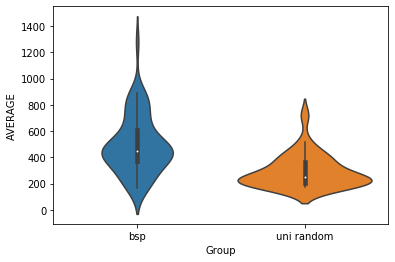

In [5]:
sns.violinplot(x="Group", y="AVERAGE", data=df)

## Violinplot with all replications

In [9]:
df_melt = pd.melt(df, id_vars=['RBS', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
df_melt = df_melt.dropna()

In [10]:
df_melt.sort_values(by = ['value']).tail(10)

,RBS,Group,variable,value
186,ATGTATATCTCCTTCTTTAA,bsp,Rep3,968.565815
191,ATGTATATCTCCTTCCTAAA,bsp,Rep3,985.743381
181,ATGTATATCTCCTTCTTAAT,bsp,Rep3,1012.121212
179,ATGTATATCTCCTTCTTAAG,bsp,Rep3,1054.585153
226,ATGGATATCTCCTTCTTAAA,bsp,Rep3,1075.510204
190,ATGTATATCTCCTTCGTAAA,bsp,Rep3,1102.345416
238,ATGTATAGTCAACTCTTAAA,uni random,Rep3,1105.577689
89,ATGTATATCTCCTTCTTAAA,bsp,Rep2,1160.377358
0,ATGTATATCTCCTTCTTAAA,bsp,Rep1,1194.444444
178,ATGTATATCTCCTTCTTAAA,bsp,Rep3,1486.111111


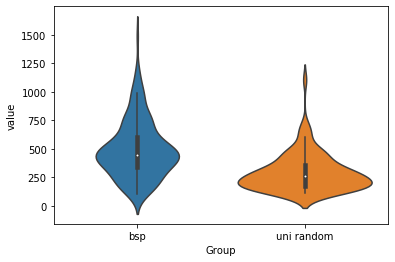

In [11]:
sns.violinplot(x="Group", y="value", data=df_melt)